In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord

In [4]:
integrationtime = 1/2
currenttime = 0 

In [5]:
MWparams = tstrippy.Parsers.pouliasis2017pii()
dtfactor = 1/100
staticgalaxy = ["pouliasis2017pii", MWparams]
G = MWparams[0]
M = 1e5
a = 5e-3
NP = int(1e2)
aplum = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(a)
tau = STR.plummer_dynamical_time([G,M,a])

In [6]:
targetGC = "NGC5139"
initialkinematics = STR.pick_GC_get_kinematics(targetGC)

In [7]:
integrationparameters = STR.prepare_integration_arguments(currenttime=currenttime,
                                                          integrationtime=integrationtime,
                                                          tdyn=tau,
                                                          alpha=dtfactor)

print("nsteps", integrationparameters[-1])
integrationparameters = list(integrationparameters)


nsteps 131072


In [8]:
args = initialkinematics, staticgalaxy, integrationparameters
orbit, timestamps, comptime = STR.integrate_host_orbit_back(args)

integration time:  0:00:00.359983


In [9]:
integrationparameters

[0, np.float64(3.814697265625e-06), 131072]

In [11]:
inithostperturber = [timestamps, *orbit, G, M, aplum ]
xp,yp,zp,vxp,vyp,vzp = tstrippy.ergodic.isotropicplummer(G,M,a,NP)
integrationparameters_stream = [timestamps[0],*integrationparameters[1:]]
initialkinematics_stream = [xp+orbit[0,0], yp+orbit[1,0], zp+orbit[2,0], vxp+orbit[3,0], vyp+orbit[4,0], vzp+orbit[5,0]]

In [12]:
streaminit = np.array([xp, yp, zp, vxp, vyp, vzp]).T + orbit[:,0]

In [13]:
args_stream = initialkinematics_stream, staticgalaxy, integrationparameters_stream, inithostperturber
stream,tesc, comptime = STR.generate_stream(args_stream)
print(f"Stream generation took {comptime} seconds")

Stream generation took 28.683254 seconds


In [14]:
# dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,0][:,np.newaxis]).T
dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,-1][:,np.newaxis])
dr = np.sqrt(dx**2 + dy**2 + dz**2)
phi0 = -G*M/(dr**2 + aplum**2)**(1/2)
T0 = (1/2) * (dvx**2 + dvy**2 + dvz**2) 
E0 = phi0 + T0

In [25]:
NSTEP = int(1e6)
NP = int(1e5)
Nc = 80e-9
Nmc = 50
NGC = 165
comptime=Nmc*NGC*NSTEP*NP*Nc * u.s
comptime.to(u.day) / 100

<Quantity 7.63888889 d>

$$C(N_p, N_{\text{Steps}}) = A \cdot N_p^\alpha \cdot N_{\text{Steps}}^\beta $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$

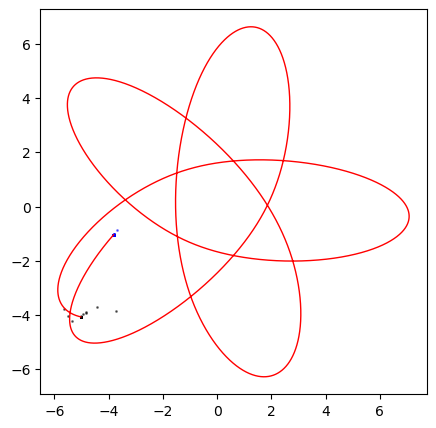

In [16]:
fig,axis= plt.subplots(1,1,figsize=(8.25-2,5))
axis.scatter(stream[0], stream[1], s=1, c='k', alpha=0.5)
axis.scatter(xp+orbit[0,0], yp+orbit[1,0], s=1, c='b', alpha=0.5, label='Stream particles')
axis.plot(orbit[0],orbit[1], c='r', lw=1, label='Host orbit')
axis.set_aspect('equal')